# Twistbytes Approach to Hierarchical Classification shared Task at GermEval 2019

We explain here, step by step, how to reproduce results of the approach and discuss parts of the paper. The approach was aimed at building a strong baseline for the task, which should be beaten by deep learning approaches, but we did not achieve that, so we submitted this baseline, and got second in the flat problem and 1st in the hierarchical task (subtask B). This baseline builds on strong placements in different shared tasks, and although it only is a clever way for keyword spotting, it performs a very good job.

## Task Description

The task was basically to classify blurbs (small summaries/advertarial texts/?) into 8 classes (subtask A) or to hierarchical structutured 343 labels. There were 11638 samples in the training set, 2910 in the development and 4157 in the test set. There are some indicators that the developement and test set were similar to the training data, as the average number of labels were similar (3.1). See https://www.inf.uni-hamburg.de/en/inst/ab/lt/resources/data/germeval-2019-hmc/gest19-1-description.pdf for a detailed description. The task is not especially useful for real applications, but one can see what can be performed by hierarchical classifiers for document classification even with few texts and a large number of labels on German text.

## Literature

Please see the detailed Task description for a general Literature. For the model, we were inspired by the architecture from https://www.researchgate.net/publication/316602155_MAZA_Submissions_to_VarDial_2017 .
Also check out the our approach used in VarDial 2018: https://blog.zhaw.ch/datascience/twist-bytes-vardial-2018/


# Approach

First, we load the libraries (we need to install also the sklearn from my fork).
We discuss here the hierarchical approach (Subtask B), to solve the 343 labels problem. The root node solution is similar but has more ngrams and higher number of maximum features.

In [1]:
#!/usr/bin/env python
"""
GermEval 2019 Hierarchical classification shared task
Twistbytes Approach (Fernando Benites)
"""

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

# needs the one from pip install git+https://github.com/fbenites/sklearn-hierarchical-classification.git
#or the developer branch
from sklearn_hierarchical_classification.classifier import HierarchicalClassifier
from sklearn_hierarchical_classification.constants import ROOT

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score, classification_report, make_scorer
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import MultiLabelBinarizer  
from sklearn.svm import LinearSVC
import numpy as np
from sklearn.multiclass import OneVsRestClassifier  

import nltk
import sys

#read data utilities
from parse_data import *
# Used for seeding random state
RANDOM_STATE = 42


We now introduce the build feature extractor. It uses many TfidfVectorizer for different n-grams (1-7 and 1-3 with German stopwords removal, and 2-3 char n-gram) to create a count matrix (Tf=> Term frequency) and weight the matrix with the inverse document frequency (idf). This creates a matrix which gives high weights/values for n-grams which occur in specific documents, and penalizes words that occur often (no document specificity). A further note, we changed here from the competition the values from 2-5 used in the submitted predictions, to 1-7 which gives a plus of 0.002 f-1 micro score.

In [2]:
def build_feature_extractor():
    context_features = FeatureUnion(
        transformer_list=[
            ('word', TfidfVectorizer(
                strip_accents=None,
                lowercase=True,
                analyzer='word',
                ngram_range=(1, 7),
                max_df=1.0,
                min_df=0.0,
                binary=False,
                use_idf=True,
                smooth_idf=True,
                sublinear_tf=True,
                max_features=70000
            )),
            ('word3', TfidfVectorizer(
                strip_accents=None,
                lowercase=True,
                analyzer='word',
                ngram_range=(1, 3),
                max_df=1.0,
                min_df=0.0,
                binary=False,
                use_idf=True,
                smooth_idf=True,
                sublinear_tf=True,
                stop_words=nltk.corpus.stopwords.words('german'),
                max_features=70000
            )),
            ('char', TfidfVectorizer(
                strip_accents=None,
                lowercase=False,
                analyzer='char',
                ngram_range=(2, 3),
                max_df=1.0,
                min_df=0.0,
                binary=False,
                use_idf=True,
                smooth_idf=True,
                sublinear_tf=True,
            )),
        ]
    )

    features = FeatureUnion(
        transformer_list=[
            ('context', Pipeline(
                steps=[('vect', context_features)]
            )),
        ]
    )

    return features

We create a function to nice print the results

In [3]:
def print_results(fname,hierarchy,y_pred,mlb,ids,graph):
    
        it_hi=[tj for tk in hierarchy.values() for tj in tk]
        roots=[tk for tk in hierarchy if tk not in it_hi]
        prec=lambda x: [tk for tk in graph.predecessors(x )]+ [tk for tj  in graph.predecessors(x )for tk in prec(tj)]
        with open(fname, "w") as f1:
            for task in range(2):
                if task==0:
                    f1.write("subtask_a\n")
                    for i in range(y_pred.shape[0]):
                        f1.write(ids[i]+"\t")
                        st1=""
                        labs=set()
                        for j in y_pred[i,:].nonzero()[0]:
                            if mlb.classes_[j] in roots:
                                st1+=mlb.classes_[j][2:]+"\t"
                            else:
                                for tk in prec(mlb.classes_[j]):
                                    if tk==-1:
                                        continue
                                    if tk[0]=="0":
                                        labs.add(tk[2:])
                        f1.write(st1[:-1]+"\t".join(labs)+"\n")
                if task==1:
                    f1.write("subtask_b\n")
                    for i in range(y_pred.shape[0]):
                        f1.write(ids[i]+"\t")
                        st1=""
                        for j in y_pred[i,:].nonzero()[0]:
                            st1+=mlb.classes_[j][2:]+"\t"
                        f1.write(st1[:-1]+"\n")

To the main part, first we load the data. Important here, the blurbs*.txt are in fact xml, which we load with a helper script. For that we diverge from the original data, by wrapping the content of the files with a root node. This is fixed in the data from my github directory.

In [4]:
if __name__ == "__main__":
    train=1
    
    if "data" not in globals():
        if train==1:
            data,labels=read_data("blurbs_train.txt")
            data_dev,labels_dev=read_data("blurbs_dev.txt")
        else:
            data,labels=read_data("blurbs_train_and_dev.txt")
            data_dev,labels_dev=read_data("blurbs_test_nolabel.txt")

        hierarchy, levels=read_hierarchy("hierarchy.txt")
        
    r"""Test that a nontrivial hierarchy leaf classification behaves as expected.
    We build the following class hierarchy along with data from the handwritten digits dataset:
            <ROOT>
           /      \
          A        B
         / \       |  \
        1   7      C   9
                 /   \
                3     8
    """
    if "ROOT" in hierarchy:
        hierarchy[ROOT] = hierarchy["ROOT"]
        del hierarchy["ROOT"]
    class_hierarchy = hierarchy

    keywords = ["title","authors","body","copyright","isbn"]

Then we transform the labels and divide train and test set. Here we differentiate between the training and the test set, since they depend on different data chunks.

In [5]:
    mlb = MultiLabelBinarizer()
    
    #depending on the mode load different data
    if train==1:
        data_train=["\n".join([tk[ky] for ky in keywords if tk[ky]!=None]) for tk in data ]

        labels_train=mlb.fit_transform(labels)

        X_train_raw, X_dev_raw, y_train, y_dev = train_test_split(data_train,labels_train,test_size=0.2,random_state=42)

    else:
        X_train_raw=["\n".join([tk[ky] for ky in keywords if tk[ky]!=None]) for tk in data ]
        y_train=mlb.fit_transform(labels)
        y_train = mlb.transform(labels)

        del data

        ids= [tk["isbn"] for tk in data_dev]
        X_dev_raw=["\n".join([tk[ky] for ky in keywords if tk[ky]!=None]) for tk in data_dev ]


                                          

We now initialize the classification pipeline. First the vectorizer, then a liner SVM in a one vs rest manner. This we glue together in a pipeline creating a base classifier. The pipeline ensures that the result of the vectorizer is given as input to the classifier. We then call the hierarchical classifier with this base classifier. The selection of algorithm lcn and training_strategy siblings makes that the base classifier is trained in each node so that it decides which child of the parent is likely to be predicted.

In [6]:
    vectorizer = build_feature_extractor()
    bclf = OneVsRestClassifier(LinearSVC())

    base_estimator = make_pipeline(
        vectorizer, bclf)

    clf = HierarchicalClassifier(
        base_estimator=base_estimator,
        class_hierarchy=class_hierarchy,
        algorithm="lcn", training_strategy="siblings",
        preprocessing=True,
        mlb=mlb,
        use_decision_function=True
    )

To create the training and prediction is really easy:

In [7]:
    print("training classifier")
    clf.fit(X_train_raw, y_train[:,:])
    print("predicting")
    y_pred_scores = clf.predict_proba(X_dev_raw)

training classifier


/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 8 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 9 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 11 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 12 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 13 is present in all training

/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5 is present in all training exa

/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 62 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 63 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 64 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 65 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 68 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 69 is present in all traini

/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5 is present in all training exa

/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 139 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 140 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 141 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 142 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 143 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 144 is present in all 

/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 203 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 204 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 206 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 207 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 208 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 210 is present in all 

/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 260 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 261 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 262 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 263 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 264 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 265 is present in all 

/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5 is present in all training exa

/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 149 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 150 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 151 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 152 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 153 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 154 is present in all 

/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 224 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 225 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 226 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 227 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 229 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 230 is present in all 

/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 278 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 279 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 280 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 282 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 283 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 284 is present in all 

/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 335 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 336 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 338 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 339 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 340 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 342 is present in all 

/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 237 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 238 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 239 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 240 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 241 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 242 is present in all 

/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5 is present in all training exa

/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5 is present in all training exa

/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 167 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 168 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 169 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 170 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 171 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 172 is present in all 

/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 327 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 328 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 329 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 330 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 331 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 332 is present in all 

/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 158 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 159 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 160 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 161 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 162 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 163 is present in all 

/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 296 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 297 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 299 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 301 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 302 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 303 is present in all 

/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 9 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 11 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 12 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 13 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 14 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 17 is present in all trainin

/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 74 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 75 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 76 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 78 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 79 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 80 is present in all traini

/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5 is present in all training exa

/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5 is present in all training exa

/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5 is present in all training exa

/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 268 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 270 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 271 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 272 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 273 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 274 is present in all 

/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5 is present in all training exa

/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 273 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 274 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 275 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 276 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 277 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 278 is present in all 

/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5 is present in all training exa

/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5 is present in all training exa

/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5 is present in all training exa

/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5 is present in all training exa

/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5 is present in all training exa

/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5 is present in all training exa

/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 72 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 73 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 74 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 75 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 76 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 77 is present in all traini

/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5 is present in all training exa

/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 303 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 304 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 305 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 306 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 307 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 308 is present in all 

/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5 is present in all training exa

/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5 is present in all training exa

/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5 is present in all training exa

/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5 is present in all training exa

/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5 is present in all training exa

/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5 is present in all training exa

/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 81 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 82 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 83 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 84 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 85 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 86 is present in all traini

/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5 is present in all training exa

/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 184 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 185 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 186 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 187 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 188 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 189 is present in all 

/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5 is present in all training exa

/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5 is present in all training exa

/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5 is present in all training exa

/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 273 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 274 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 275 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 276 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 277 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 278 is present in all 

/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5 is present in all training exa

/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 59 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 60 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 61 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 62 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 63 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 64 is present in all traini

/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5 is present in all training exa

/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 318 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 319 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 320 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 321 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 322 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 323 is present in all 

/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 280 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 281 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 282 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 283 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 284 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 285 is present in all 

/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5 is present in all training exa

/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 225 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 226 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 227 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 228 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 229 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 230 is present in all 

/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5 is present in all training exa

/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 291 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 292 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 293 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 294 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 295 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 296 is present in all 

/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5 is present in all training exa

/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5 is present in all training exa

/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5 is present in all training exa

/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5 is present in all training exa

/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5 is present in all training exa

/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 286 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 287 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 288 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 289 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 290 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 291 is present in all 

/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5 is present in all training exa

/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5 is present in all training exa

/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5 is present in all training exa

/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5 is present in all training exa

/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5 is present in all training exa

/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5 is present in all training exa

/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5 is present in all training exa

/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5 is present in all training exa

/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5 is present in all training exa

/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5 is present in all training exa

/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 70 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 71 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 72 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 73 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 74 is present in all training examples.
  str(classes[c]))
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 75 is present in all traini

predicting


The point of the approach was also to set a right threshold.
We show the curve by changing the threshold:
    

The classifier linearSVC outputs values betwee -1 and 1. But for nodes which did not have any prediction, the hierarchical classifier let it to 0. So first we set every value which is zero to a lower value than -1 (here -10).

In [8]:
y_pred_scores[np.where(y_pred_scores==0)]=-10

Now we choose a good threshold. Lets see how the graph was for the development set, if we change the threshold.

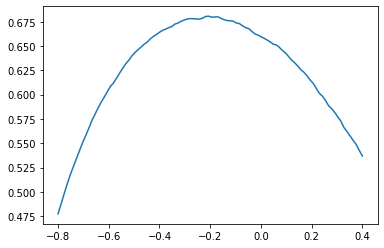

In [13]:
import matplotlib.pyplot as plt
x_graph=np.linspace(-0.8,0.4,100)
y_graph=[f1_score(y_true=y_dev, y_pred=y_pred_scores>tx, average='micro') for tx in x_graph]
plt.plot(x_graph,y_graph)

We can see that the f1-score is almost convex and the top is around -0.2. We can chose -0.25 because it seemed more stable on the right side of the top.

In [14]:
y_pred=y_pred_scores>-0.25

We print it out (if you want you can use train=0 and get the predictions for the final result).

In [15]:


    
    if train==1:
        print('f1 micro:',
          f1_score(y_true=y_dev, y_pred=y_pred, average='micro'))
        print('f1 macro:',
          f1_score(y_true=y_dev, y_pred=y_pred, average='macro'))
        print(classification_report(y_true=y_dev, y_pred=y_pred))
    else:
        import networkx as nx
        graph = nx.DiGraph(hierarchy)
        print_results("submission_baseline.txt",hierarchy,y_pred>-0.25,mlb,ids,graph)

f1 micro: 0.677735500980053
f1 macro: 0.24667277524584916
              precision    recall  f1-score   support

           0       1.00      0.72      0.84        32
           1       0.71      0.80      0.75       138
           2       0.86      0.69      0.76       112
           3       0.88      0.85      0.87       412
           4       0.94      0.77      0.85        22
           5       0.87      0.98      0.92      1608
           6       0.79      0.86      0.82       394
           7       0.70      0.72      0.71       412
           8       0.62      0.56      0.59        61
           9       0.57      0.58      0.57       106
          10       0.00      0.00      0.00        16
          11       1.00      0.45      0.62        11
          12       0.00      0.00      0.00         5
          13       0.56      0.71      0.63        14
          14       0.00      0.00      0.00         1
          15       0.60      0.45      0.51        83
          16       0.00

/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/fbenites/virtualenvs/germeval/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 't

At the end in the competition, in the figure below, we see that in this subtask the micro-F1 was linked to recall, since most approaches focused in precision, we could achieve with the threshold strategy the best result.


![SubTaskB_Results](./SubTaskB_Results.png) 


